In [33]:
import os
import pandas as pd
from utils import generateResultsSingleImage
import numpy as np

base_dir = '/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_3/20241203_0 and 30 mM app data'
results_dir = "./results"

def parse_filename(filename):
    
    data = filename.split('_')
    
    sensor_id = data[0]  
    test_id = data[1]    # Test ID 
    concentration = data[2]  # Concentration level 
    height_code = data[3]  # Height 
    lighting = data[4].replace('.png', '')  

    height = convert_height(height_code)

    return sensor_id, test_id, concentration, height, lighting

def convert_height(height_code):
    
    return {
        'h1': '30-35 cm',
        'h2': '15-20 cm'
    }.get(height_code, 'Unknown')

def process_images_in_directory(base_dir, results_dir):
    
    metadata = []

    for filename in os.listdir(base_dir):
        print(filename)
        if filename.endswith(".png"):
            sensor_id, test_id, concentration, height, lighting = parse_filename(filename)
            image_path = os.path.join(base_dir, filename)
            base_image_path = '/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_3/20241203_0 and 30 mM app data/study_Blank/basesensor_1_Blank_h1_420 LUX.png'
            print(f"Processing {filename}...")
            output = generateResultsSingleImage(base_image_path, image_path, results_dir)
            metrics = output[1]
            
            if metrics is not None:
                base_avg = {
                    "Channel Mean R": np.mean([region["channel_means"][0] for region in metrics["base_image"]]),
                    "Channel Mean G": np.mean([region["channel_means"][1] for region in metrics["base_image"]]),
                    "Channel Mean B": np.mean([region["channel_means"][2] for region in metrics["base_image"]])
                }

                target_avg = {
                    "Channel Mean R": np.mean([region["channel_means"][0] for region in metrics["target_image"]]),
                    "Channel Mean G": np.mean([region["channel_means"][1] for region in metrics["target_image"]]),
                    "Channel Mean B": np.mean([region["channel_means"][2] for region in metrics["target_image"]])
                }

                metadata.append({
                    'Sensor ID': sensor_id,
                    'Test ID': test_id,
                    'Concentration': concentration,
                    'Height': height,
                    'Lighting': lighting,
                    'Base Channel Mean R': base_avg["Channel Mean R"],
                    'Base Channel Mean G': base_avg["Channel Mean G"],
                    'Base Channel Mean B': base_avg["Channel Mean B"],
                    'Target Channel Mean R': target_avg["Channel Mean R"],
                    'Target Channel Mean G': target_avg["Channel Mean G"],
                    'Target Channel Mean B': target_avg["Channel Mean B"]
                })
                print(f"Output for {filename}: {metrics}")
            else:
                print(f"Failed to process {filename}: No output.")

    return metadata

all_metadata = []
study_folders = os.listdir(base_dir)
for study_folder in study_folders:
    print(study_folder)
    if study_folder.startswith('study_'): 
        study_dir = os.path.join(base_dir, study_folder)
        print(study_dir)
        if os.path.isdir(study_dir):
            study_metadata = process_images_in_directory(study_dir, results_dir)
            if study_metadata:
                all_metadata.extend(study_metadata)

df_all = pd.DataFrame(all_metadata)

print(df_all)

output_csv_path = os.path.join(results_dir, 'image_metadata_with_results.csv')
df_all.to_csv(output_csv_path, index=False)
print(f"Metadata and results saved to {output_csv_path}")

Out of app data
study_30mM
/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_3/20241203_0 and 30 mM app data/study_30mM
basesensor_3_30mM2_h1_360 lux.png
Processing basesensor_3_30mM2_h1_360 lux.png...
/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_3/20241203_0 and 30 mM app data/study_Blank/basesensor_1_Blank_h1_420 LUX.png /Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_3/20241203_0 and 30 mM app data/study_30mM/basesensor_3_30mM2_h1_360 lux.png
Working on baseImage..
4
4
Working on image..
3
3
Global Base Image Mean: [173.01562 131.4653  179.85641], Std: [55.152554 12.814877 26.092384]
Target Image Assay 1 - Channel-Wise Mean Intensities: [np.float64(54.887949260042284), np.float64(135.0), np.float64(179.0242537313433)]
Target Image Assay 2 - Channel-Wise Mean Intensities: [np.float64(74.65046296296296), np.float64(157.80160

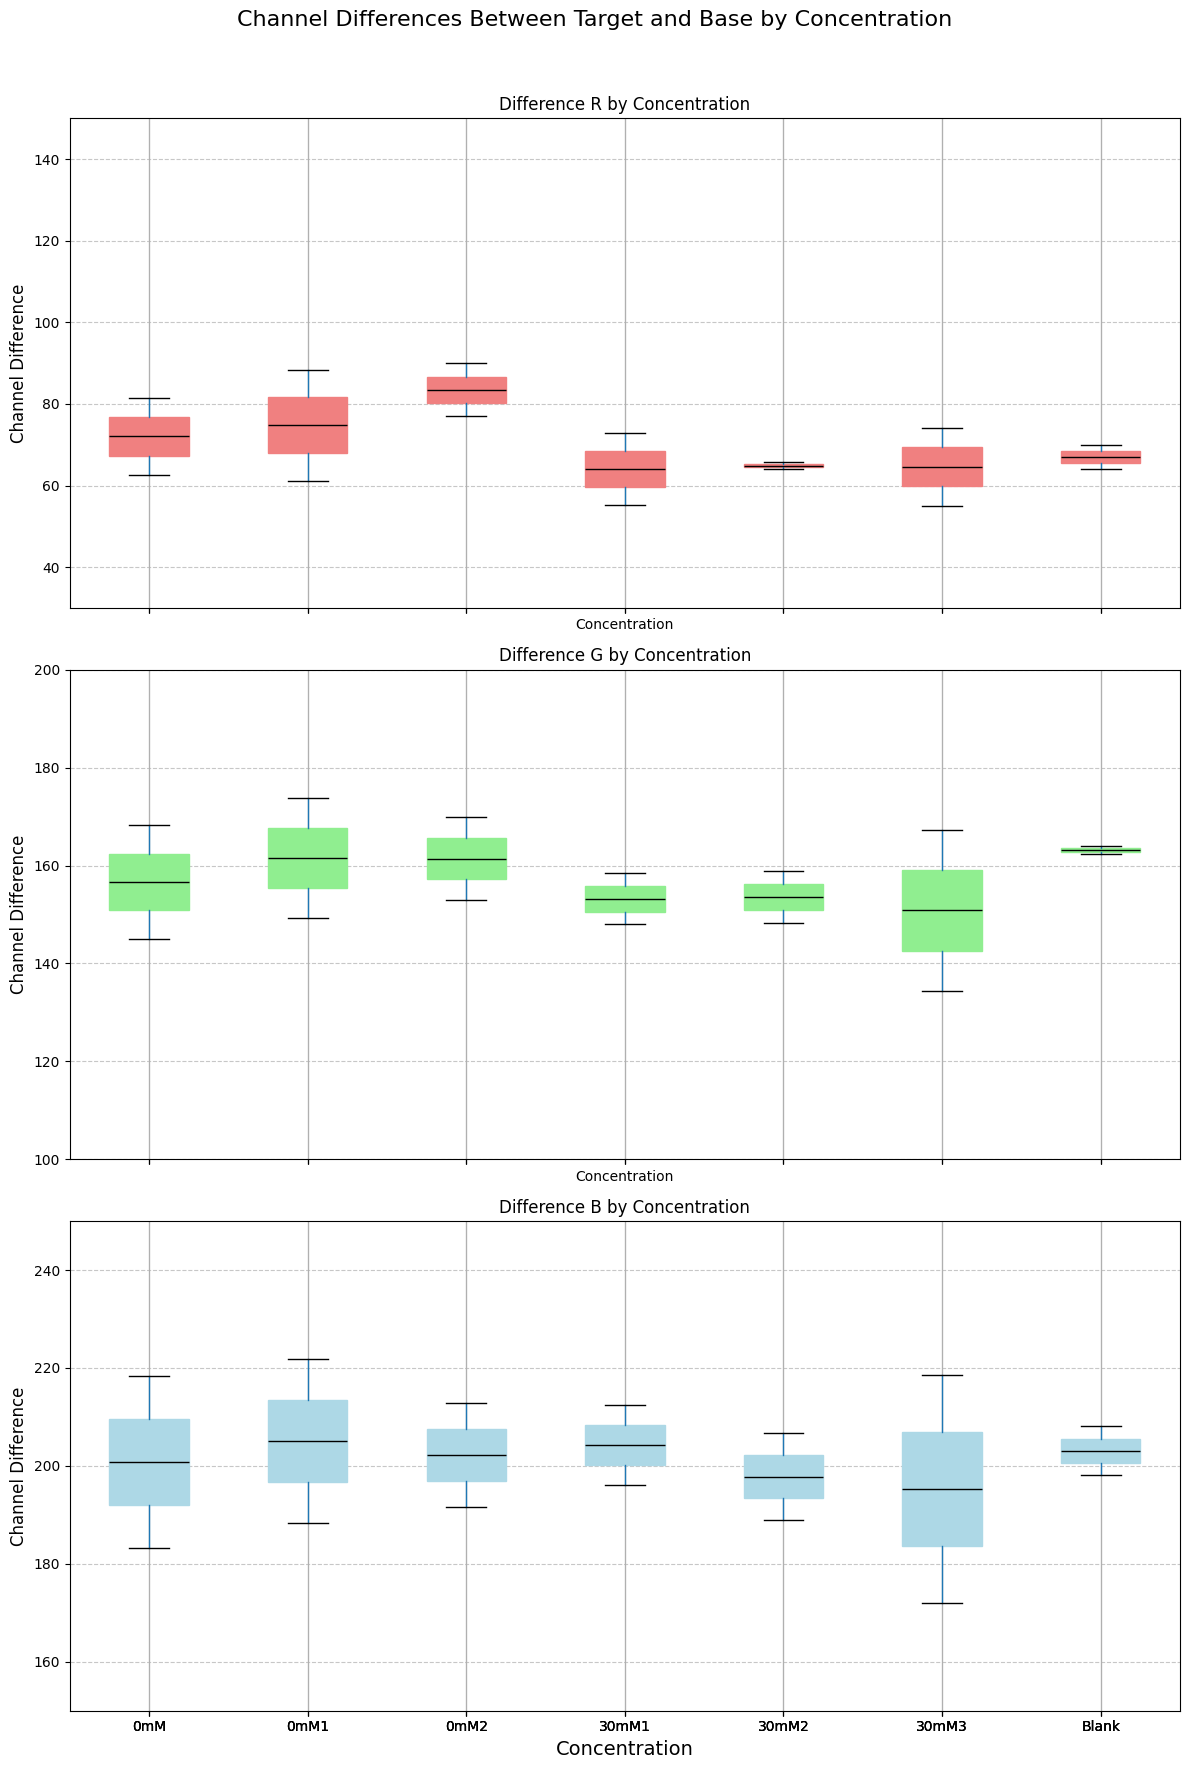

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_all

numeric_columns = [
    'Base Channel Mean R', 'Base Channel Mean G', 'Base Channel Mean B',
    'Target Channel Mean R', 'Target Channel Mean G', 'Target Channel Mean B'
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')



df['Difference R'] = df['Target Channel Mean R'] 
df['Difference G'] = df['Target Channel Mean G'] 
df['Difference B'] = df['Target Channel Mean B'] 

channels = ['Difference R', 'Difference G', 'Difference B']
colors = ['lightcoral', 'lightgreen', 'lightblue']
y_ranges = [(30, 150), (100, 200), (150, 250)]

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for ax, channel, y_range, color in zip(axes, channels, y_ranges, colors):
    df.boxplot(
        column=[channel],
        by='Concentration',
        patch_artist=True,
        grid=True,
        ax=ax,
        boxprops=dict(facecolor=color, color=color),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor=color)
    )

    ax.set_title(f'{channel} by Concentration')
    ax.set_ylabel('Channel Difference', fontsize=12)
    ax.set_ylim(y_range)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Concentration', fontsize=14)
plt.suptitle('Channel Differences Between Target and Base by Concentration', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [ ]:
import os
import pandas as pd
from utils import generateResultsSingleImage
import numpy as np
import re


def parse_filename(filename):
    data = filename.split('_')
    print(data)
    
    concentration = data[3].replace("mM", "").strip() 

    height_code = data[4].strip().split('_')[0] 
    height = convert_height(height_code)

    # lighting = data[4].replace('.png', '')  # Remove file extension to get lighting value
    return concentration, height


def convert_height(height_code):
    return {
        'h1': '30-35 cm',
        'h2': '15-20 cm'
    }.get(height_code, 'Unknown')

def process_images_in_directory(base_dir, results_dir):
    metadata = []

    for filename in os.listdir(base_dir):
        if filename.endswith(".png"):
            print(f"Processing {filename}...")
            concentration, height = parse_filename(filename)
            image_path = os.path.join(base_dir, filename)
            base_image_path = '/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_4/basesensor_1_blank Pristine.png'
            
            output = generateResultsSingleImage(base_image_path, image_path, results_dir)
            metrics = output[1]
            
            if metrics is not None:
                base_avg = {
                    "Channel Mean R": np.mean([region["channel_means"][0] for region in metrics["base_image"]]),
                    "Channel Mean G": np.mean([region["channel_means"][1] for region in metrics["base_image"]]),
                    "Channel Mean B": np.mean([region["channel_means"][2] for region in metrics["base_image"]])
                }

                target_avg = {
                    "Channel Mean R": np.mean([region["channel_means"][0] for region in metrics["target_image"]]),
                    "Channel Mean G": np.mean([region["channel_means"][1] for region in metrics["target_image"]]),
                    "Channel Mean B": np.mean([region["channel_means"][2] for region in metrics["target_image"]])
                }

                metadata.append({
                    # 'Sensor ID': sensor_id,
                    # 'Test ID': test_id,
                    'Concentration': concentration,
                    'Height': height,
                    # 'Lighting': lighting,
                    'Base Channel Mean R': base_avg["Channel Mean R"],
                    'Base Channel Mean G': base_avg["Channel Mean G"],
                    'Base Channel Mean B': base_avg["Channel Mean B"],
                    'Target Channel Mean R': target_avg["Channel Mean R"],
                    'Target Channel Mean G': target_avg["Channel Mean G"],
                    'Target Channel Mean B': target_avg["Channel Mean B"]
                })
            else:
                print(f"Failed to process {filename}: No output.")

    return metadata

base_dir = '/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_4/20241213_0 and 30mM'
results_dir = "./results"

all_metadata = []
study_folders = os.listdir(base_dir)

study_metadata = process_images_in_directory(base_dir, results_dir)
if study_metadata:
    all_metadata.extend(study_metadata)

df_all = pd.DataFrame(all_metadata)

print(df_all)

output_csv_path = os.path.join(results_dir, 'image_metadata_with_results.csv')
df_all.to_csv(output_csv_path, index=False)
print(f"Metadata and results saved to {output_csv_path}")


Processing basesensor_14_4_30mM_h2.png...
['basesensor', '14', '4', '30mM', 'h2.png']
/Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_4/basesensor_1_blank Pristine.png /Users/apparilalith/ASU Dropbox/Lalith Appari/Mac/Desktop/asu/mayolab/woundsensor/ios_app/test_images_4/20241213_0 and 30mM/basesensor_14_4_30mM_h2.png
Working on baseImage..
4
4
Working on image..
4
4
Global Base Image Mean: [187.13416 129.0391  186.97932], Std: [55.232075  9.63387  23.961811]
Target Image Assay 1 - Channel-Wise Mean Intensities: [np.float64(71.6139455782313), np.float64(170.96955128205127), np.float64(222.28846153846155)]
Target Image Assay 2 - Channel-Wise Mean Intensities: [np.float64(72.78374836173002), np.float64(163.64532019704433), np.float64(205.1293103448276)]
Target Image Assay 3 - Channel-Wise Mean Intensities: [np.float64(81.60282574568289), np.float64(165.83384615384617), np.float64(205.14923076923077)]
Target Image Assay 4 - Channel-Wis

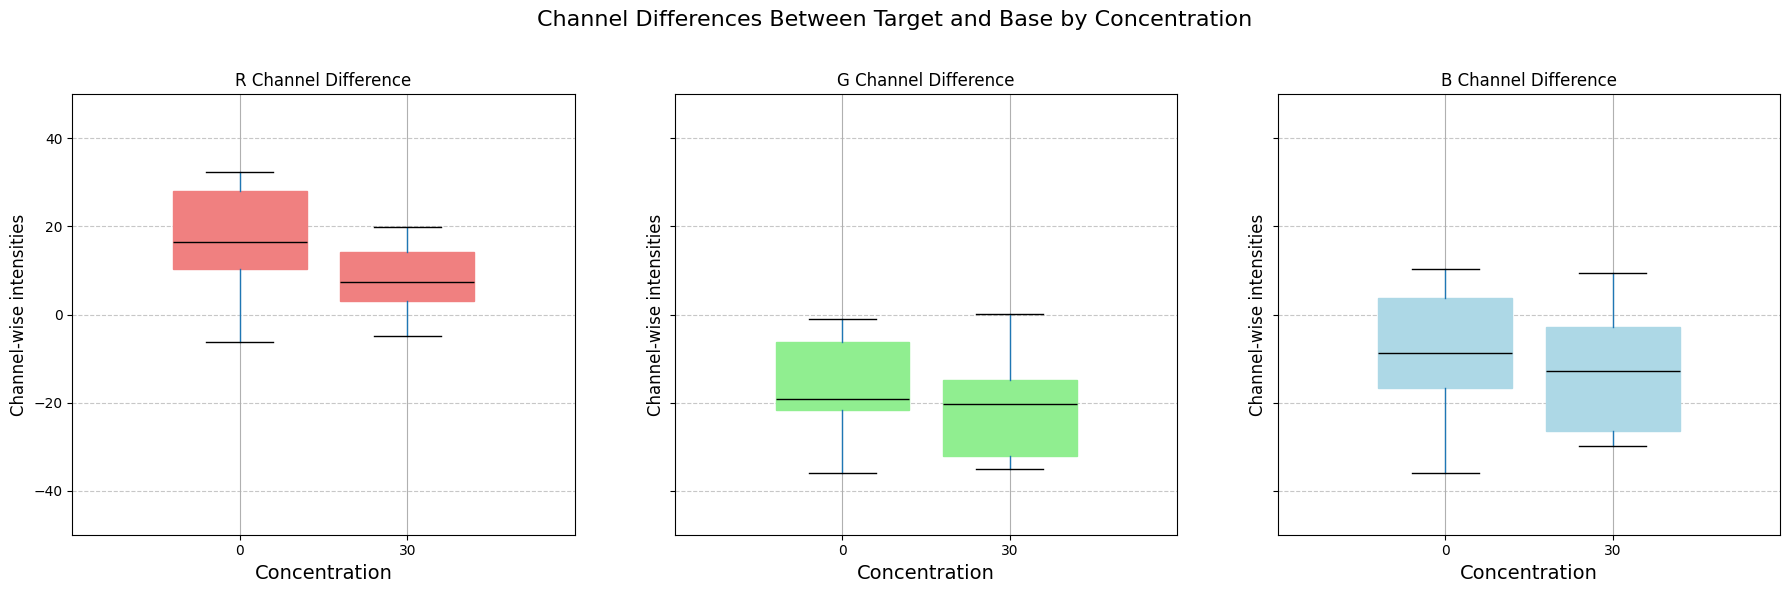

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_all

numeric_columns = [
    'Base Channel Mean R', 'Base Channel Mean G', 'Base Channel Mean B',
    'Target Channel Mean R', 'Target Channel Mean G', 'Target Channel Mean B'
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

df['R'] = (df['Target Channel Mean R'] - df['Base Channel Mean R'])
df['G'] = (df['Target Channel Mean G'] - df['Base Channel Mean G'])
df['B'] = (df['Target Channel Mean B'] - df['Base Channel Mean B'])

channels = ['R', 'G', 'B']
colors = ['lightcoral', 'lightgreen', 'lightblue']
y_range = (-50, 50)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, channel, color in zip(axs, channels, colors):
    df.boxplot(
        column=[channel],
        by='Concentration',
        patch_artist=True,
        grid=True,
        ax=ax,
        boxprops=dict(facecolor=color, color=color),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor=color),
        widths=0.8  
    )
    ax.set_title(f'{channel} Channel Difference')
    ax.set_xlabel('Concentration', fontsize=14)
    ax.set_ylabel('Channel-wise intensities', fontsize=12)
    ax.set_ylim(y_range)
    ax.set_xlim(0, 3)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Channel Differences Between Target and Base by Concentration', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(wspace=0.2)  

plt.show()
